In [19]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import unicodedata
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
import enchant


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder

ImportError: The 'enchant' C library was not found. Please install it via your OS package manager, or use a pre-built binary wheel from PyPI.

In [ ]:
#Read and cleanup
df = pd.read_csv('data/movie_all_genre.csv')
d = enchant.Dict("en_US")


indexes = df[ df['genre'] == 'News'].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'] == 'Game-Show'].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'] == 'Reality-TV'].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'] == 'Talk-Show'].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'] == 'Short'].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'] == 'Biography'].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'] == 'Film-Noir'].index
df.drop(indexes, inplace=True)
indexes = df[ d.check(df['movie']) is not true ].index
df.drop_duplicates(subset='movie', inplace=True)


In [11]:
df['genre_id'] = df['genre'].factorize()[0]
category_id_df = df[['genre', 'genre_id']].drop_duplicates().sort_values('genre_id')
categories = np.unique(df['genre'].values)
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['genre_id', 'genre']].values)
df.head()

,movie,genre,genre_id
0,Abracadabra,Musical,0
4,Bob's New Suit,Drama,1
5,Bad Dog and Superhero,Comedy,2
6,A ForÃ§a do XangÃ´,Drama,1
7,Bob Hope: The Road to Laughter,Documentary,3


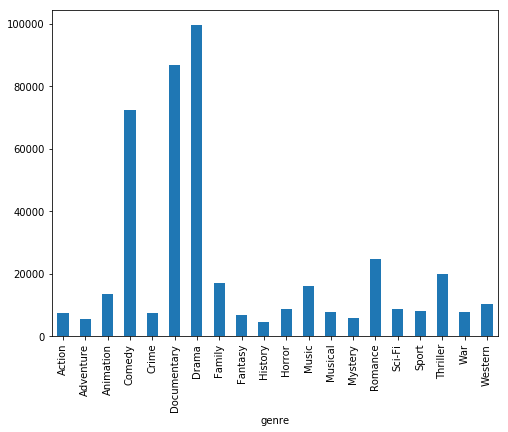

In [12]:
fig = plt.figure(figsize=(8,6))
df.groupby('genre').movie.count().plot.bar(ylim=0)
plt.show()

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.movie)
labels = df.genre_id
features.shape

(437419, 39949)

In [15]:
from sklearn.feature_selection import chi2
N = 2
for movie, genre_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == genre_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(movie))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Action':
  . Most correlated unigrams:
. pwg
. narcos
  . Most correlated bigrams:
. wwf house
. la mafia
# 'Adventure':
  . Most correlated unigrams:
. bound
. bondage
  . Most correlated bigrams:
. nude bondage
. dangerous diva
# 'Animation':
  . Most correlated unigrams:
. nobita
. filminuto
  . Most correlated bigrams:
. vesyolaya karusel
. doraemon nobita
# 'Comedy':
  . Most correlated unigrams:
. pimple
. comedy
  . Most correlated bigrams:
. bobby bumps
. kri kri
# 'Crime':
  . Most correlated unigrams:
. tod
. mord
  . Most correlated bigrams:
. maigret et
. bienzle und
# 'Documentary':
  . Most correlated unigrams:
. playboy
. making
  . Most correlated bigrams:
. mã xico
. panoramic view
# 'Drama':
  . Most correlated unigrams:
. making
. woman
  . Most correlated bigrams:
. satsujin jiken
. passion play
# 'Family':
  . Most correlated unigrams:
. porky
. hare
  . Most correlated bigrams:
. winnie pooh
. need know
# 'Fantasy':
  . Most correlated unigrams:
. darna
. event

In [178]:
#Naive Bayes
count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(x_train)
tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
clf = MultinomialNB().fit(x_train_tfidf, y_train)

In [179]:
print(clf.predict(count_vect.transform(["The killer"])))
print(clf.predict(count_vect.transform(["'Crocodile' Dundee II"])))
print(clf.predict(count_vect.transform(["Mystery Science Theater"])))
print(clf.predict(count_vect.transform(["titan Legends"])))


['Short']
['Comedy']
['Short']
['Documentary']


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

models = [
    LinearSVC(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
filter_length = 300
max_words = 7500
maxlen = 200
num_classes = len(np.unique(df.genre))
print(num_classes)

def get_features(text_series):
    sequences = tokenizer.texts_to_sequences(text_series)
    return pad_sequences(sequences, maxlen=maxlen)

def prediction_to_label(prediction):
    tag_prob = [(labels[i], prob) for i, prob in enumerate(prediction.tolist())]

def baseline_model():
    # create model
    model = Sequential()
    model.add(Embedding(max_words, 20, input_length=maxlen))
    model.add(Dropout(0.1))
    model.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
    model.add(GlobalMaxPool1D())
    model.add(Dense(26))
    model.add(Activation('sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy'])
    return model

In [134]:
encoder = LabelEncoder()
encoder.fit(categories)
encoded_Y = encoder.transform(categories)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

(26, 26)

In [130]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=maxwords, lower=True)
tokenizer.fit_on_texts(df.movie)
sequences = tokenizer.texts_to_sequences(df.movie)
x = pad_sequences(sequences, maxlen=500)
x.shape

(447639, 500)

In [139]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit(df.genre)
labels = mlb.classes_
y = mlb.transform(df.genre)
y.shape
np.unique(df.genre)

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
       'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Sport', 'Talk-Show',
       'Thriller', 'War', 'Western'], dtype=object)

In [132]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9000)

In [133]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D

callbacks = [
    ReduceLROnPlateau(), 
    EarlyStopping(patience=4), 
    ModelCheckpoint(filepath='model-conv1d.h5', save_best_only=True)
]

model = baseline_model()

import tensorflow as tf


history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=callbacks)

Train on 322299 samples, validate on 35812 samples
Epoch 1/20
322299/322299 [==============================] - 180s 559us/step - loss: 0.3359 - categorical_accuracy: 3.5681e-04 - val_loss: 0.3369 - val_categorical_accuracy: 4.7470e-04
Epoch 2/20
322299/322299 [==============================] - 176s 547us/step - loss: 0.3308 - categorical_accuracy: 9.6805e-04 - val_loss: 0.3359 - val_categorical_accuracy: 0.0018
Epoch 3/20
322299/322299 [==============================] - 175s 543us/step - loss: 0.3295 - categorical_accuracy: 0.0013 - val_loss: 0.3339 - val_categorical_accuracy: 0.0013
Epoch 4/20
322299/322299 [==============================] - 176s 545us/step - loss: 0.3287 - categorical_accuracy: 0.0013 - val_loss: 0.3322 - val_categorical_accuracy: 0.0015
Epoch 5/20
322299/322299 [==============================] - 175s 544us/step - loss: 0.3281 - categorical_accuracy: 0.0013 - val_loss: 0.3316 - val_categorical_accuracy: 0.0014
Epoch 6/20
322299/322299 [==============================]